## 1. Dataset preparation
In this section I include the required libraries and load the datasest into memory using Pandas

In [26]:
# My best friends ever
# Other notebable
import gc
import os
import pickle
# Text and Parsing
import re
import string
# You say what?
import warnings
from collections import Counter
from urllib.parse import urlparse

# Gradient Boosting
import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from pandas_profiling import ProfileReport
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn import preprocessing
from sklearn.cross_validation import KFold
# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from tqdm import tqdm

# Data Viz
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

%matplotlib inline

warnings.filterwarnings("ignore")

### Load the files

In [31]:
preloaded = False

In [32]:
submission = pd.read_csv("data/sample_submission.csv", index_col="Webpage_id")

In [33]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
traindex = train.index
testdex = test.index

In [30]:
print("test shape: {} \ntrain shape: {}".format(test.shape, train.shape))

test shape: (25787, 3) 
train shape: (53447, 4)


In [11]:
train.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...,news


In [12]:
test.head()

,Webpage_id,Domain,Url
0,31,isrctn.com,http://www.isrctn.com/ISRCTN57801413
1,32,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
2,33,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
3,34,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
4,35,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...


In [6]:
y = train.Tag.copy()
train.drop("Tag", axis=1, inplace=True)

In [10]:
df = pd.concat([train, test], axis=0)

In [11]:
df.shape

(79234, 3)

In [12]:
df.head()

,Webpage_id,Domain,Url
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...


__html_data__ file is too big to be read in one piece so we'll load it in chunks with the help of Pandas.

In [13]:
%%time
if preloaded == False:
    chunks = pd.read_csv("data/html_data.csv", chunksize=1000)

    html = pd.DataFrame()
    html = pd.concat(chunk for chunk in chunks)

    # Save the html dataframe to pickle file to load it directly next time
    with open("data/html_raw.pkl", "wb") as pkl:
        pickle.dump(html, pkl, protocol=2)

else:
    with open("data/html_raw.pkl", "rb") as pkl:
        html = pickle.load(pkl)

CPU times: user 8.93 s, sys: 13.1 s, total: 22 s
Wall time: 1min 47s


In [14]:
html.shape

(79345, 2)

In [15]:
gc.collect()

353

### Parse HTML with BeautifulSoup library

In [16]:
def cleanHtml(html):
    soup = BeautifulSoup(html, "lxml")

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()  # rip it out

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = " ".join(chunk for chunk in chunks if chunk)
    return text

In [17]:
%%time
if preloaded == False:
    # Create and register a new `tqdm` instance with `pandas`
    # (can use tqdm_gui, optional kwargs, etc.)
    tqdm.pandas()
    html["html_text"] = html["Html"].progress_apply(lambda x: cleanHtml(x))
    gc.collect()
    # Save the html dataframe to pickle file to load it directly next time
    with open("data/html_text.pkl", "wb") as pkl:
        pickle.dump(html_text, pkl, protocol=2)
else:
    with open("data/html.pkl", "rb") as pkl:
        html_text = pickle.load(pkl)

CPU times: user 1.74 s, sys: 1.66 s, total: 3.4 s
Wall time: 12 s


In [18]:
html["html_text"] = html_text

## 2. EDA
Let's explore the data a little bit

In [19]:
labels = set(y)
print(labels)

{'guidelines', 'publication', 'profile', 'forum', 'others', 'news', 'conferences', 'clinicalTrials', 'thesis'}


In [20]:
train["Domain"].value_counts().head(10)

thesis.library.caltech.edu           301
dspace.mit.edu                       300
curate.nd.edu                        300
www.dart-europe.eu                   300
ecommons.cornell.edu                 300
academiccommons.columbia.edu         300
www.nice.org.uk                      230
www.ncbi.nlm.nih.gov                 226
ctri.nic.in                          209
www.australiancancertrials.gov.au    209
Name: Domain, dtype: int64

In [21]:
test["Domain"].value_counts().head(10)

repository.library.georgetown.edu    300
resolver.caltech.edu                 300
www.kofam.ch                         210
www.clinicaltrialsregister.eu        208
www.ensaiosclinicos.gov.br           206
www.pactr.org                        206
www.mims.co.uk                       200
isrctn.com                           200
www.drks.de                          200
www.guidelinecentral.com             200
Name: Domain, dtype: int64

How many unique values are in Domain feature?

In [22]:
print(
    "unique domain names in train: {:.2f}%\ntest: {:.2f}%".format(
        train["Domain"].nunique() / len(train) * 100,
        test["Domain"].nunique() / len(test) * 100,
    )
)

unique domain names in train: 7.44%
test: 8.34%


Let's see if there are any interconnections

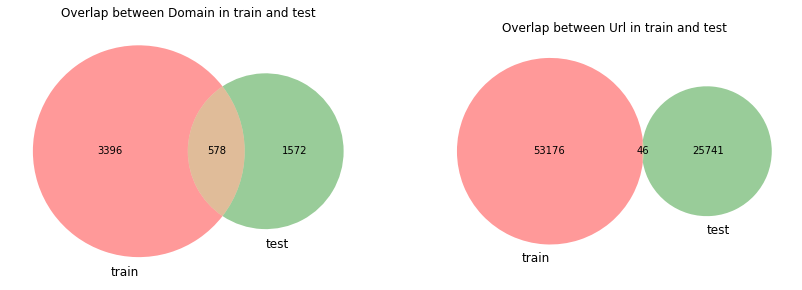

In [23]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 7))


def get_venn(axarr, feature):
    axarr[0].set_title(f"Overlap between {feature[0]} in train and test")
    venn2(
        [set(train[feature[0]].values), set(test[feature[0]].values)],
        set_labels=("train", "test"),
        ax=axarr[0],
    )
    axarr[1].set_title(f"Overlap between {feature[1]} in train and test")
    venn2(
        [set(train[feature[1]].values), set(test[feature[1]].values)],
        set_labels=("train", "test"),
        ax=axarr[1],
    )


get_venn(axarr, ["Domain", "Url"])

## 3. Feature Engineering

### Features from raw html and text

In [24]:
%%time
html["html_text_char_count"] = html["html_text"].apply(len)
html["html_text_num_caps"] = html["html_text"].apply(
    (lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
)
html["html_text_caps_vs_char_count"] = (
    html["html_text_num_caps"] / html["html_text_char_count"] * 100
)
html["html_text"] = html[
    "html_text"
].str.lower()  # Lowercase all text, so that capitalized words dont get treated differently
html["html_text_num_words"] = html["html_text"].apply(
    lambda comment: len(comment.split())
)  # Count number of Words
html["html_text_num_unique_words"] = html["html_text"].apply(
    lambda comment: len(set(w for w in comment.split()))
)
html["html_text_words_vs_unique"] = (
    html["html_text_num_unique_words"] / html["html_text_num_words"] * 100
)  # Count Unique Words
html["html_text_num_punctuation"] = html["html_text"].apply(
    lambda x: len("".join(_ for _ in x if _ in string.punctuation))
)
html["html_text_num_digits"] = html["html_text"].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.isdigit()])
)
html["html_text_pun_vs_char_count"] = (
    html["html_text_num_punctuation"] / html["html_text_char_count"] * 100
)
html["html_text_digits_vs_char_count"] = (
    html["html_text_num_digits"] / html["html_text_char_count"] * 100
)

CPU times: user 2min 26s, sys: 3.18 s, total: 2min 30s
Wall time: 2min 30s


In [25]:
%%time
html["num_a"] = html["Html"].apply(lambda comment: (comment.count("<a href")))
html["num_pics"] = html["Html"].apply(lambda comment: (comment.count("<img")))
html["num_link"] = html["Html"].apply(lambda comment: (comment.count("<link")))
html["num_div"] = html["Html"].apply(lambda comment: (comment.count("<div")))
html["num_you"] = html["Html"].apply(lambda comment: (comment.count("youtube")))

CPU times: user 32.8 s, sys: 9.54 ms, total: 32.8 s
Wall time: 32.8 s


In [26]:
html_feats = html.columns[3:]

In [27]:
df_index = df.index
df = df.merge(html.drop("Html", axis=1), on="Webpage_id", how="left").set_index(
    df_index
)

In [28]:
%%time
df["url_path"] = df["Url"].apply(lambda x: urlparse(x).path)
df["url_query"] = df["Url"].apply(lambda x: urlparse(x).query)

CPU times: user 1.12 s, sys: 8.25 ms, total: 1.13 s
Wall time: 1.12 s


In [29]:
%%time
df["path"] = df.url_path.apply(lambda x: 1 if x != "" else 0)
df["query"] = df.url_query.apply(lambda x: 1 if x != "" else 0)

df["num_symbols"] = df.Url.apply(
    lambda comment: len(comment)
)  # Count number of symbols in URL
df["num_alphanumeric"] = df.Url.apply(
    lambda comment: (sum(c.isalpha() for c in comment))
)  # Count number of AlphaNumeric
df["num_nonalpha"] = df["num_symbols"] - df["num_alphanumeric"]
df["num_digits"] = df.Url.apply(
    lambda comment: (sum(c.isdigit() for c in comment))
)  # Count number of Digits
df["num_slashes"] = df.Url.apply(
    lambda comment: (comment.count("/"))
)  # Count number of slashes
df["num_dashes"] = df.Url.apply(
    lambda comment: (comment.count("-"))
)  # Count number of dashes
df["num_dots"] = df.Url.apply(
    lambda comment: (comment.count("."))
)  # Count number of dashes
df["num_&"] = df.Url.apply(lambda comment: (comment.count("&")))  # Count number of &
df["num_equals"] = df.Url.apply(
    lambda comment: (comment.count("="))
)  # Count number of equal signs
df["num_unders"] = df.Url.apply(
    lambda comment: (comment.count("_"))
)  # Count number of underlines
df["num_%"] = df.Url.apply(
    lambda comment: (comment.count("%"))
)  # Count number of % signs
df["alpha_share"] = df.num_alphanumeric / df.num_symbols
df["non_alpha_share"] = df.num_nonalpha / df.num_symbols

CPU times: user 1.84 s, sys: 498 µs, total: 1.84 s
Wall time: 1.84 s


In [30]:
df.columns

Index(['Webpage_id', 'Domain', 'Url', 'html_text', 'html_text_char_count',
       'html_text_num_caps', 'html_text_caps_vs_char_count',
       'html_text_num_words', 'html_text_num_unique_words',
       'html_text_words_vs_unique', 'html_text_num_punctuation',
       'html_text_num_digits', 'html_text_pun_vs_char_count',
       'html_text_digits_vs_char_count', 'num_a', 'num_pics', 'num_link',
       'num_div', 'num_you', 'url_path', 'url_query', 'path', 'query',
       'num_symbols', 'num_alphanumeric', 'num_nonalpha', 'num_digits',
       'num_slashes', 'num_dashes', 'num_dots', 'num_&', 'num_equals',
       'num_unders', 'num_%', 'alpha_share', 'non_alpha_share'],
      dtype='object')

### Vectorizing URLs

In [31]:
%%time
vectorizer = CountVectorizer(
    analyzer="word",
    min_df=0.01,
    decode_error="ignore",
    ngram_range=(1, 1),
    dtype=np.int32,
)

# applying Vectorizer to preprocessed tweets
ready_df = vectorizer.fit_transform(df["Url"])

# creating (word, count) list
sub12 = zip(vectorizer.get_feature_names(), np.asarray(ready_df.sum(axis=0)).ravel())

CPU times: user 1.12 s, sys: 8.28 ms, total: 1.13 s
Wall time: 1.2 s


In [32]:
# getting Top20 words
sorted(sub12, key=lambda x: x[1], reverse=True)[0:10]

[('http', 48745),
 ('com', 42805),
 ('www', 33008),
 ('https', 30577),
 ('org', 19088),
 ('html', 8426),
 ('10', 8153),
 ('edu', 7011),
 ('news', 5974),
 ('en', 5526)]

In [33]:
vect_vocab = vectorizer.get_feature_names()

In [38]:
df.drop(
    ["Webpage_id", "Domain", "Url", "url_path", "url_query", "html_text"],
    axis=1,
    inplace=True,
)

In [39]:
df.head()

,html_text_char_count,html_text_num_caps,html_text_caps_vs_char_count,html_text_num_words,html_text_num_unique_words,html_text_words_vs_unique,html_text_num_punctuation,html_text_num_digits,html_text_pun_vs_char_count,html_text_digits_vs_char_count,...,num_digits,num_slashes,num_dashes,num_dots,num_&,num_equals,num_unders,num_%,alpha_share,non_alpha_share
0,7901,57,0.721428,1252,653,52.156550,245,14,3.100873,0.177193,...,1,4,15,2,0,0,0,0,0.816000,0.184000
1,5953,54,0.907106,955,504,52.774869,166,14,2.788510,0.235176,...,0,4,10,2,0,0,0,0,0.819149,0.180851
2,4671,42,0.899165,686,412,60.058309,151,12,3.232712,0.256904,...,0,4,11,2,0,0,0,0,0.828571,0.171429
3,4394,32,0.728266,666,392,58.858859,121,11,2.753755,0.250341,...,0,4,9,2,0,0,0,0,0.822222,0.177778
4,4939,30,0.607410,746,391,52.412869,115,10,2.328407,0.202470,...,0,4,10,2,0,0,0,0,0.849558,0.150442


In [40]:
df.apply(lambda x: len(x.unique()))

html_text_char_count              25705
html_text_num_caps                 1589
html_text_caps_vs_char_count      62783
html_text_num_words                8908
html_text_num_unique_words         3706
html_text_words_vs_unique         55589
html_text_num_punctuation          3910
html_text_num_digits                553
html_text_pun_vs_char_count       68790
html_text_digits_vs_char_count    54706
num_a                              1148
num_pics                            292
num_link                             81
num_div                            1081
num_you                              78
path                                  2
query                                 2
num_symbols                         329
num_alphanumeric                    267
num_nonalpha                        147
num_digits                           88
num_slashes                          15
num_dashes                           37
num_dots                             17
num_&                                14


In [41]:
# df = np.log1p(df)

### Encode Variables

In [42]:
# Encoder:
# lbl = preprocessing.LabelEncoder()
# df['Domain'] = lbl.fit_transform(df['Domain'])

In [7]:
lbl_y = preprocessing.LabelEncoder()
lbl_y.fit(y)
y = lbl_y.transform(y)

### Combine Dense Features with Sparse Text Bag of Words Features

In [9]:
%%time
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack(
    [csr_matrix(df.iloc[: train.shape[0], :].values), ready_df[0 : traindex.shape[0]]]
)  # Sparse Matrix

testing = hstack(
    [csr_matrix(df.iloc[train.shape[0] :, :].values), ready_df[traindex.shape[0] :]]
)

full_vocab = df.columns.tolist() + vect_vocab

CPU times: user 1.87 s, sys: 2.13 s, total: 4 s
Wall time: 4.03 s


In [ ]:
del df, html, train, test, ready_df, ready_tfdf
gc.collect()

## 4. Modeling

In [11]:
lgbm_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "multiclass",
    #'class_weight': 'balanced', # new parameter!
    "metric": "multi_logloss",
    "num_class": 9,
    "max_depth": 15,
    "num_leaves": 300,
    "feature_fraction": 0.6,
    "bagging_fraction": 0.8,
    "bagging_freq": 2,
    "learning_rate": 0.0175,
    "verbose": 0,
}

In [12]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.10, random_state=42
)

CPU times: user 19.1 s, sys: 2.8 s, total: 22 s
Wall time: 22 s


In [13]:
gc.collect()

0

In [14]:
# LGBM Dataset Formatting
lgtrain = lgb.Dataset(
    X_train,
    y_train,
    feature_name=full_vocab,
    # categorical_feature = categorical
)
lgvalid = lgb.Dataset(
    X_valid,
    y_valid,
    feature_name=full_vocab,
    # categorical_feature = categorical
)

In [15]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.reshape(-1, 9)
    preds = preds.argmax(axis=1)
    f_score = f1_score(labels, preds, average="weighted")
    return "f1_score", f_score, True


evals_result = {}

In [ ]:
%%time
# Go Go Go
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=100,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=10,
    verbose_eval=1,
    # feval=evalerror,
    # evals_result=evals_result
)

### Model Evaluation

In [18]:
# lgb.plot_metric(evals_result, metric='f1_score');

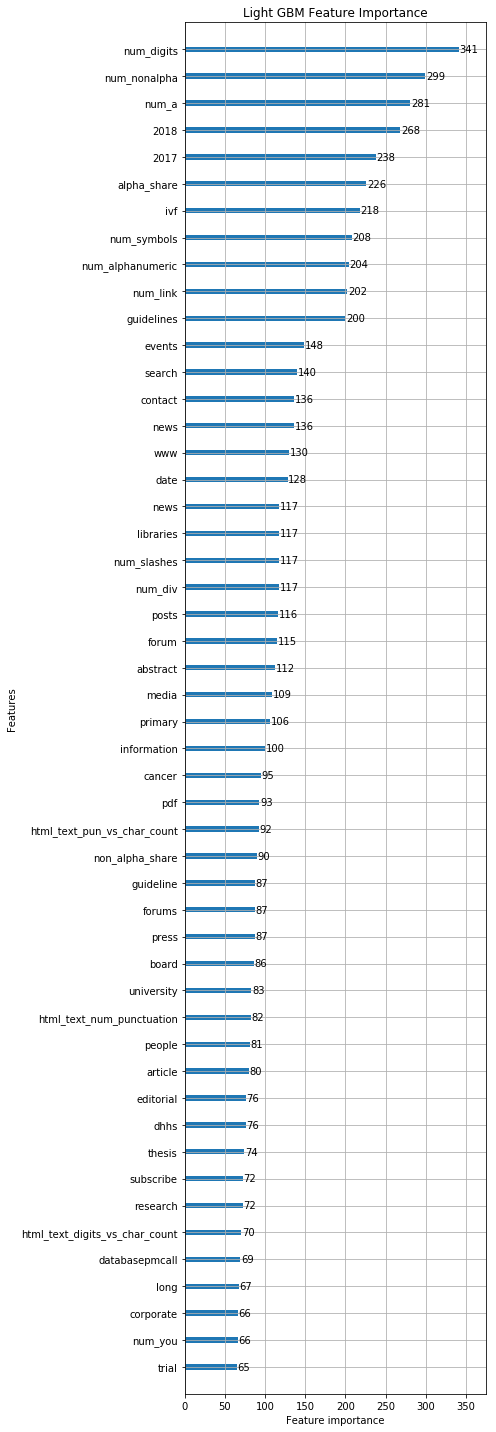

In [19]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7, 20])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.tight_layout()
plt.title("Light GBM Feature Importance")
plt.savefig("feature_import.png")

In [20]:
lgpred = lgb_clf.predict(testing)

In [21]:
with open("data/lgpred.pkl", "wb") as pkl:
    pickle.dump(lgpred, pkl, protocol=2)

In [22]:
lgpred = np.apply_along_axis(np.argmax, 1, lgpred)

In [23]:
lgpred = lbl_y.inverse_transform(lgpred)

In [24]:
submission["Tag"] = lgpred

In [25]:
submission.to_csv("lgsub.csv", index=True, header=True)